In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time

from xgboost import XGBRegressor
from xgboost import plot_importance

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import LabelEncoder
from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm
from sklearn import preprocessing
from xgboost import plot_tree
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

# Kaggle- https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/evaluation
#ref https://www.kaggle.com/dlarionov/feature-engineering-xgboost

In [2]:
train  = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
test  = pd.read_csv('test.csv').set_index('ID')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


## CHECKING FOR OUTLIERS

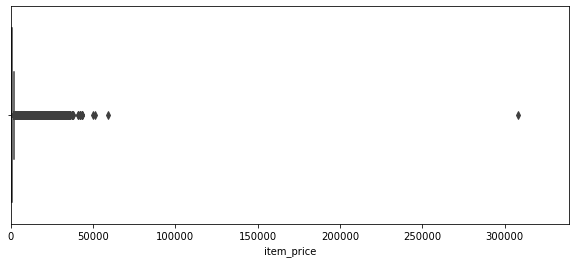

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

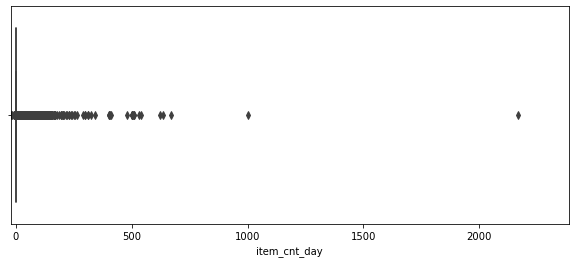

In [8]:
plt.figure(figsize=(10,4))
plt.xlim(train.item_cnt_day.min(), train.item_cnt_day.max()*1.1)
sns.boxplot(x=train.item_cnt_day)

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and quantity > 1001.

In [9]:
train.shape

(2935849, 6)

In [10]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [11]:
train.shape

(2935847, 6)

## CLEANING AND FIXING THE TRAIN DATA

Item price cannot be negative, let us fill it with median

In [12]:
train.item_price.min()

-1.0

In [13]:
train[train["item_price"]<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [14]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [15]:
train[train["item_price"]<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [16]:
train["shop_id" ].nunique()

60

In [17]:
shops["shop_id"].nunique()

60

In [18]:
shops["shop_name"].nunique()

60

Checking few duplicates in shop names (shop_id=0 and 57),(1,58),(10,11) Also observing test data, we have that shops 0,1,10 are not there in the shop id column

In [19]:
shops[shops['shop_id']==57]

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57


In [20]:
shops[shops['shop_id']==0]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [21]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:

Each shop_name starts with the city name.\
Each category contains type and subtype in its name.

In [22]:
#Сергиев Посад  is the city name
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

# Якутск is misspelt as !Якутск
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [23]:
shops = shops[['shop_id','city_code']]

In [24]:

#strip() method returns a copy of the string by removing both the leading and the trailing characters (based on the string argument passed)
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])

cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


In [25]:
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## NEW ITEMS IN TEST SET

In [26]:
len(test)

214200

In [27]:
# 363 new items in test which are not in train

len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id))))

363

In [28]:
# All the shop ids which are in test are in train also
len(set(test.shop_id))-len(set(test.shop_id.unique()).intersection(set(train["shop_id"].unique())))

0

In [29]:
len(list(set(test.item_id)))

5100

In [30]:
len(list(set(test.shop_id)))

# 42*5100= 214200

42

Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

## Aggregating the train data

In [31]:
# itertools product
"""Input : arr1 = [1, 2, 3]
arr2 = [5, 6, 7]
return list(product(arr1, arr2)) 
Output : [(1, 5), (1, 6), (1, 7), (2, 5), (2, 6), (2, 7), (3, 5), (3, 6), (3, 7)]"""

# here we are aggregating all combinations of day, shop and item, 
#since sales is the super set of train, we have all data in sales

matrix = []
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    

In [32]:
len(matrix[0])

365175

In [33]:
sales.shop_id.nunique()

44

In [34]:
sales.item_id.nunique()

5413

In [35]:
45*8115

365175

In [36]:
cols = ['date_block_num','shop_id','item_id']

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

matrix.sort_values(cols,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [37]:
# Now we can get a column having each month actual transactions from the train data and then 
#append that to matrix we defined before

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [38]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [39]:
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [40]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


## Appending the train data to test data

In [41]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

## Feature Engineering

In [42]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [43]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [44]:
# Lagging of Total sales

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


In [45]:
x=matrix[matrix["shop_id"]==4]
x[x["item_id"]==32].head(15)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
16234,0,4,32,2.0,2,40,11,4,NaN,NaN,NaN,NaN,NaN
381516,1,4,32,1.0,2,40,11,4,2.0,NaN,NaN,NaN,NaN
757511,2,4,32,4.0,2,40,11,4,1.0,2.0,NaN,NaN,NaN
1139089,3,4,32,0.0,2,40,11,4,4.0,1.0,2.0,NaN,NaN
1514148,4,4,32,1.0,2,40,11,4,0.0,4.0,1.0,NaN,NaN
1889680,5,4,32,0.0,2,40,11,4,1.0,0.0,4.0,NaN,NaN
2279523,6,4,32,1.0,2,40,11,4,0.0,1.0,0.0,2.0,NaN
2665405,7,4,32,1.0,2,40,11,4,1.0,0.0,1.0,1.0,NaN
3026489,8,4,32,1.0,2,40,11,4,1.0,1.0,0.0,4.0,NaN
3381236,9,4,32,1.0,2,40,11,4,1.0,1.0,1.0,0.0,NaN


## MEAN OF ALL SALES 

In [46]:
# Month wise mean

matrix['date_avg_item_cnt']=matrix.groupby(['date_block_num'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')

In [47]:
#Month wise and item_id wise

matrix['date_item_avg_item_cnt']=matrix.groupby(['date_block_num','item_id'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1,2,3,6,12], 'date_item_avg_item_cnt')

In [48]:
# Month wise and shop_id wise

matrix['date_shop_avg_item_cnt']=matrix.groupby(['date_block_num','shop_id'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1,2,3,6,12], 'date_shop_avg_item_cnt')

In [49]:
# Month wise and category_id wise

matrix['date_cat_avg_item_cnt']=matrix.groupby(['date_block_num','item_category_id'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1], 'date_cat_avg_item_cnt')

In [50]:
# Month wise,shop_id and category_id wise

matrix['date_shop_cat_avg_item_cnt']=matrix.groupby(['date_block_num','shop_id','item_category_id'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1], 'date_shop_cat_avg_item_cnt')

In [51]:
# Month wise,shop_id and type_code wise

matrix['date_shop_type_avg_item_cnt']=matrix.groupby(['date_block_num','shop_id','type_code'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1], 'date_shop_type_avg_item_cnt')

In [52]:
# Month wise,shop_id and subtype_code wise

matrix['date_shop_subtype_avg_item_cnt']=matrix.groupby(['date_block_num','shop_id','subtype_code'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1], 'date_shop_subtype_avg_item_cnt')

In [53]:
# Month wise and city_code

matrix['date_city_avg_item_cnt']=matrix.groupby(['date_block_num','city_code'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1], 'date_city_avg_item_cnt')

In [54]:
# Month wise,item_id and city_code wise

matrix['date_item_city_avg_item_cnt']=matrix.groupby(['date_block_num', 'item_id', 'city_code'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1], 'date_item_city_avg_item_cnt')

In [55]:
# Month wise and type_code

matrix['date_type_avg_item_cnt']=matrix.groupby(['date_block_num','type_code'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1], 'date_type_avg_item_cnt')

In [56]:
# Month wise and type_code

matrix['date_subtype_avg_item_cnt']=matrix.groupby(['date_block_num','subtype_code'])["item_cnt_month"].transform("mean")
matrix = lag_feature(matrix,  [1], 'date_subtype_avg_item_cnt')

In [57]:
matrix.drop(columns=["date_avg_item_cnt","date_subtype_avg_item_cnt","date_type_avg_item_cnt",\
                    "date_item_city_avg_item_cnt","date_city_avg_item_cnt","date_shop_subtype_avg_item_cnt",\
                    "date_shop_type_avg_item_cnt","date_shop_cat_avg_item_cnt","date_cat_avg_item_cnt",\
                     "date_shop_avg_item_cnt","date_item_avg_item_cnt"],inplace=True)

## TREND OF SALES

In [58]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')


In [59]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,28.000000
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.228571,2325.000000
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.010465,549.000000
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759.285714,2397.500000
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.629240,338.110349


In [69]:
matrix["date_block_num"].unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34], dtype=int8)

In [90]:
# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559


def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [91]:
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']
    

    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(features_to_drop, axis=1, inplace=True)

In [92]:
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

## MODELLING

In [93]:
matrix = matrix[matrix.date_block_num > 11]

In [94]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,month,days,delta_price_lag
0,12,2,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.411377,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,0.955566,0.808594,0.935059,0.148071,0.0,1.03418,1.075195,0,31,0.0
1,12,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.411377,1.021484,1.022461,0.521973,0.891113,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.291504,0.046234,0.051727,0.046234,0.148071,0.0,0.27002,0.291504,0,31,0.0
2,12,2,31,0.0,0,37,11,1,0.0,0.0,0.0,0.0,0.0,0.411377,0.543457,0.600098,0.543457,0.304443,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.232788,0.059448,0.051727,0.064697,0.148071,0.0,0.27002,0.234009,0,31,0.0
3,12,2,32,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.411377,1.934570,1.799805,1.260742,1.891602,5.378906,0.148071,0.100647,0.08905,0.096008,0.141235,0.291504,0.046234,0.051727,0.046234,0.148071,0.0,0.27002,0.291504,0,31,0.0
4,12,2,33,1.0,0,37,11,1,1.0,2.0,0.0,0.0,1.0,0.411377,0.913086,0.333252,0.717285,1.000000,1.355469,0.148071,0.100647,0.08905,0.096008,0.141235,0.232788,0.059448,0.051727,0.064697,0.148071,1.0,0.27002,0.234009,0,31,0.0


In [95]:
matrix.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
item_cnt_month                          0
city_code                               0
item_category_id                        0
type_code                               0
subtype_code                            0
item_cnt_month_lag_1                    0
item_cnt_month_lag_2                    0
item_cnt_month_lag_3                    0
item_cnt_month_lag_6                    0
item_cnt_month_lag_12                   0
date_avg_item_cnt_lag_1                 0
date_item_avg_item_cnt_lag_1            0
date_item_avg_item_cnt_lag_2            0
date_item_avg_item_cnt_lag_3            0
date_item_avg_item_cnt_lag_6            0
date_item_avg_item_cnt_lag_12           0
date_shop_avg_item_cnt_lag_1            0
date_shop_avg_item_cnt_lag_2            0
date_shop_avg_item_cnt_lag_3            0
date_shop_avg_item_cnt_lag_6            0
date_shop_avg_item_cnt_lag_12     

In [96]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [97]:
matrix.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
item_cnt_month                          0
city_code                               0
item_category_id                        0
type_code                               0
subtype_code                            0
item_cnt_month_lag_1                    0
item_cnt_month_lag_2                    0
item_cnt_month_lag_3                    0
item_cnt_month_lag_6                    0
item_cnt_month_lag_12                   0
date_avg_item_cnt_lag_1                 0
date_item_avg_item_cnt_lag_1            0
date_item_avg_item_cnt_lag_2            0
date_item_avg_item_cnt_lag_3            0
date_item_avg_item_cnt_lag_6            0
date_item_avg_item_cnt_lag_12           0
date_shop_avg_item_cnt_lag_1            0
date_shop_avg_item_cnt_lag_2            0
date_shop_avg_item_cnt_lag_3            0
date_shop_avg_item_cnt_lag_6            0
date_shop_avg_item_cnt_lag_12     

In [99]:
data=matrix.copy()

In [100]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [103]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[16:11:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06265	validation_1-rmse:1.05567
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.98333	validation_1-rmse:1.00227
[2]	validation_0-rmse:0.93716	validation_1-rmse:0.97194
[3]	validation_0-rmse:0.90679	validation_1-rmse:0.95074
[4]	validation_0-rmse:0.88845	validation_1-rmse:0.94139
[5]	validation_0-rmse:0.87632	validation_1-rmse:0.93912
[6]	validation_0-rmse:0.86857	validation_1-rmse:0.93679
[7]	validation_0-rmse:0.86157	validation_1-rmse:0.93528
[8]	validation_0-rmse:0.85811	validation_1-rmse:0.93553
[9]	validation_0-rmse:0.85421	validation_1-rmse:0.93440
[10]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
       gpu_id=-1, importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=nan, monotone_constraints='()',
       n_estimators=1000, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
       tree_method='approx', validate_parameters=1, verbosity=None)

In [104]:
#Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)